<a href="https://colab.research.google.com/github/yeonkkk/AIFFEL-Project/blob/main/Exploration15/project/%5BE_15%5DTransformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# E-15. 트랜스포머로 만드는 대화형 챗봇




## Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용  

사용 데이터: [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)  

일부 이별과 관련된 질문에서 [다음카페 "사랑보다 아름다운 실연"]( http://cafe116.daum.net/_c21_/home?grpid=1bld )에서 자주 나오는 이야기들을 참고하여 제작된 데이터  

일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링  

데이터 shape 및 결측치 확인하였음  

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data_path = "/content/drive/MyDrive/AIffel/ex15/ChatbotData .csv"
data = pd.read_csv(data_path, encoding='utf-8')
data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [ ]:
data.groupby(['label']).count()

,Q,A
label,,
0,5290,5290
1,3570,3570
2,2963,2963


In [ ]:
df = data[['Q', 'A']]
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [ ]:
df.shape

(11823, 2)

In [ ]:
df.isnull().sum()

Q    0
A    0
dtype: int64

----
## Step 2. 데이터 전처리하기
- `preprocess_sentence`:
  
  - 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거 
  - 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제  
  - 불용어 제거: [한국어 불용어 리스트](https://mr-doosun.tistory.com/24)를 활용하였습니다.  

In [ ]:
stopwords_f = open("/content/drive/MyDrive/AIffel/ex15/stopwords.txt")
for line in stopwords_f: 
    stopwords = line.split()
stopwords_f.close()

len(stopwords)

888

In [ ]:
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ㄱ-ㅎ, ㅏ-ㅣ, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()

# 불용어 제거
  sentence_list = []
  for s in sentence.split(' '):
    if s not in stopwords:
      sentence_list.append(s)

  sentence = " ".join([str(ele) for ele in sentence_list])
  return sentence

In [ ]:
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
questions = []
answers = []
for sentence in data['Q']:
  questions.append(preprocess_sentence(sentence))

for sentence in data['A']:
  answers.append(preprocess_sentence(sentence))

In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [ ]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[1]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[1]))

전처리 후의 22번째 질문 샘플: 1지망 학교 떨어졌어
전처리 후의 22번째 답변 샘플: 위로해 드립니다 .


---
## Step 3. SubwordTextEncoder 사용하기


한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다.  
하지만 해당 프로젝트에서는 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용  

In [ ]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5764, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11568
필터링 후의 답변 샘플 개수: 11568


### 1-2. 교사강요(Teacher Forcing) 사용하기

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---
## Step 4. 모델 구성하기
- 포지셔널 인코딩 레이어

- 스케일드 닷 프로덕트 어텐션

- 멀티 헤드 어텐션

- 패딩 마스크

- 룩 어헤드 마스킹

- 인코더 층 & 인코더

- 디코더 층 & 디코더

- 트랜스포머



In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


# 멀티 헤드 어텐션 클래스
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


# 패딩 마스킹구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]


# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


# 인코더 층을 쌓아 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  

# 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3146240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model2.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3119104     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model3 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model3.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3119104     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model4 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model4.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3146240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model5 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model5.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3147008     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model6 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model6.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13653504    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 손실함수 설정

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 학습률(Learning rate) 커스텀

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 컴파일

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

Text(0.5, 0, 'Train Step')

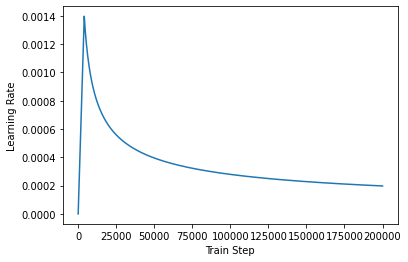

In [ ]:
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history1 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 363s 2s/step - loss: 1.4541 - accuracy: 0.0278
Epoch 2/20
185/185 [==============================] - 357s 2s/step - loss: 1.1769 - accuracy: 0.0495
Epoch 3/20
185/185 [==============================] - 356s 2s/step - loss: 1.0059 - accuracy: 0.0507
Epoch 4/20
185/185 [==============================] - 353s 2s/step - loss: 0.9302 - accuracy: 0.0542
Epoch 5/20
185/185 [==============================] - 354s 2s/step - loss: 0.8712 - accuracy: 0.0576
Epoch 6/20
185/185 [==============================] - 355s 2s/step - loss: 0.8121 - accuracy: 0.0614
Epoch 7/20
185/185 [==============================] - 356s 2s/step - loss: 0.7473 - accuracy: 0.0675
Epoch 8/20
185/185 [==============================] - 354s 2s/step - loss: 0.6741 - accuracy: 0.0754
Epoch 9/20
185/185 [==============================] - 354s 2s/step - loss: 0.5960 - accuracy: 0.0840
Epoch 10/20
185/185 [==============================] - 355s 2s/step - loss: 0.5132 - accura

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history2 = model2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 202s 1s/step - loss: 2.7720 - accuracy: 0.0607
Epoch 2/20
185/185 [==============================] - 190s 1s/step - loss: 2.2300 - accuracy: 0.1015
Epoch 3/20
185/185 [==============================] - 186s 1s/step - loss: 1.8908 - accuracy: 0.1040
Epoch 4/20
185/185 [==============================] - 186s 1s/step - loss: 1.7521 - accuracy: 0.1094
Epoch 5/20
185/185 [==============================] - 186s 1s/step - loss: 1.6518 - accuracy: 0.1143
Epoch 6/20
185/185 [==============================] - 186s 1s/step - loss: 1.5449 - accuracy: 0.1219
Epoch 7/20
185/185 [==============================] - 187s 1s/step - loss: 1.4241 - accuracy: 0.1332
Epoch 8/20
185/185 [==============================] - 186s 1s/step - loss: 1.2877 - accuracy: 0.1482
Epoch 9/20
185/185 [==============================] - 186s 1s/step - loss: 1.1365 - accuracy: 0.1650
Epoch 10/20
185/185 [==============================] - 184s 996ms/step - loss: 0.9762 - acc

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model3.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history3 = model3.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 374s 2s/step - loss: 1.3552 - accuracy: 0.0228
Epoch 2/20
185/185 [==============================] - 362s 2s/step - loss: 1.0943 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 360s 2s/step - loss: 0.9262 - accuracy: 0.0506
Epoch 4/20
185/185 [==============================] - 365s 2s/step - loss: 0.8617 - accuracy: 0.0533
Epoch 5/20
185/185 [==============================] - 365s 2s/step - loss: 0.8126 - accuracy: 0.0558
Epoch 6/20
185/185 [==============================] - 360s 2s/step - loss: 0.7606 - accuracy: 0.0593
Epoch 7/20
185/185 [==============================] - 364s 2s/step - loss: 0.7025 - accuracy: 0.0645
Epoch 8/20
185/185 [==============================] - 365s 2s/step - loss: 0.6351 - accuracy: 0.0715
Epoch 9/20
185/185 [==============================] - 366s 2s/step - loss: 0.5603 - accuracy: 0.0795
Epoch 10/20
185/185 [==============================] - 359s 2s/step - loss: 0.4809 - accura

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model4.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history4 = model4.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 190s 982ms/step - loss: 2.9653 - accuracy: 0.0449
Epoch 2/20
185/185 [==============================] - 182s 986ms/step - loss: 2.3996 - accuracy: 0.1015
Epoch 3/20
185/185 [==============================] - 181s 981ms/step - loss: 2.0433 - accuracy: 0.1038
Epoch 4/20
185/185 [==============================] - 182s 982ms/step - loss: 1.8895 - accuracy: 0.1111
Epoch 5/20
185/185 [==============================] - 181s 977ms/step - loss: 1.7711 - accuracy: 0.1178
Epoch 6/20
185/185 [==============================] - 175s 948ms/step - loss: 1.6495 - accuracy: 0.1264
Epoch 7/20
185/185 [==============================] - 179s 968ms/step - loss: 1.5155 - accuracy: 0.1390
Epoch 8/20
185/185 [==============================] - 185s 1s/step - loss: 1.3671 - accuracy: 0.1547
Epoch 9/20
185/185 [==============================] - 191s 1s/step - loss: 1.2063 - accuracy: 0.1725
Epoch 10/20
185/185 [==============================] - 195s 1s/step - 

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model5.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
model5.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
181/181 [==============================] - 145s 760ms/step - loss: 3.9573 - accuracy: 0.0805
Epoch 2/20
181/181 [==============================] - 138s 764ms/step - loss: 3.2131 - accuracy: 0.1381
Epoch 3/20
181/181 [==============================] - 138s 762ms/step - loss: 2.7186 - accuracy: 0.1407
Epoch 4/20
181/181 [==============================] - 139s 770ms/step - loss: 2.5082 - accuracy: 0.1503
Epoch 5/20
181/181 [==============================] - 139s 768ms/step - loss: 2.3497 - accuracy: 0.1596
Epoch 6/20
181/181 [==============================] - 138s 761ms/step - loss: 2.1897 - accuracy: 0.1707
Epoch 7/20
181/181 [==============================] - 138s 761ms/step - loss: 2.0155 - accuracy: 0.1857
Epoch 8/20
181/181 [==============================] - 138s 761ms/step - loss: 1.8220 - accuracy: 0.2066
Epoch 9/20
181/181 [==============================] - 141s 780ms/step - loss: 1.6135 - accuracy: 0.2296
Epoch 10/20
181/181 [==============================] - 140s 775m

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model6.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
model6.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
181/181 [==============================] - 597s 3s/step - loss: 3.6533 - accuracy: 0.0734
Epoch 2/20
181/181 [==============================] - 574s 3s/step - loss: 2.8918 - accuracy: 0.1385
Epoch 3/20
181/181 [==============================] - 574s 3s/step - loss: 2.6491 - accuracy: 0.1412
Epoch 4/20
181/181 [==============================] - 572s 3s/step - loss: 2.5289 - accuracy: 0.1474
Epoch 5/20
181/181 [==============================] - 573s 3s/step - loss: 2.4336 - accuracy: 0.1532
Epoch 6/20
181/181 [==============================] - 573s 3s/step - loss: 2.3304 - accuracy: 0.1588
Epoch 7/20
181/181 [==============================] - 573s 3s/step - loss: 2.2126 - accuracy: 0.1653
Epoch 8/20
181/181 [==============================] - 571s 3s/step - loss: 2.0753 - accuracy: 0.1752
Epoch 9/20
181/181 [==============================] - 570s 3s/step - loss: 1.9205 - accuracy: 0.1875
Epoch 10/20
181/181 [==============================] - 572s 3s/step - loss: 1.7526 - accura

---
## Step 5. 모델 평가하기


Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수 생성

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model6(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
question = ['밥 먹었어?', '잘 지내?', '오늘 우울해', '나는 커피를 좋아해', '지금 몇시지?',  '민트초코 싫어', '열심히 공부해보자', '너랑 대화하고 싶어', '놀고 싶다', '대답해줘서 고마워']

#### 1차 시도: MAX_LENGTH 40  + MAX_LENGTH 20 NUM_LAYERS 2 + D_MODEL 256

In [ ]:
for i in question:
  sentence_generation(i)

입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .
입력 : 잘 지내?
출력 : 당신은 잘 지내고 있나봅니다 .
입력 : 오늘 우울해
출력 : 우울한 이유한 생각들을 해보세요 .
입력 : 나는 커피를 좋아해
출력 : 함께 건강하게 먹어요 .
입력 : 지금 몇시지?
출력 : 꼬시지 말고 사랑해 보세요 .
입력 : 민트초코 싫어
출력 : 신경 쓸 일이 있나봐요 .
입력 : 열심히 공부해보자
출력 : 생각한대로 잘할 거예요 .
입력 : 너랑 대화하고 싶어
출력 : 너무 무리하지 마세요 .
입력 : 놀고 싶다
출력 : 저도요 ! !
입력 : 대답해줘서 고마워
출력 : 다른 사람이 반입니다 .


#### 2차 시도: 불용어 제거 + MAX_LENGTH 20  + MAX_LENGTH 20 NUM_LAYERS 2 + D_MODEL 256

In [ ]:
for i in question:
  sentence_generation(i)

입력 : 밥 먹었어?
출력 : 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 없겠없겠좋았는데 거울을 
입력 : 잘 지내?
출력 : 좋았는데 속좋았는데 안돼요안돼요안돼요안돼요안돼요안돼요솔직하안돼요솔직하안돼요솔직하안돼요집착하는 집착하는 집착하는 집착하는 솔직하
입력 : 오늘 우울해
출력 : 좋았는데 속좋았는데 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 좋았는데 좋았는데 좋았는데 거절거절자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 
입력 : 나는 커피를 좋아해
출력 : 느낌이 느낌이 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 
입력 : 지금 몇시지?
출력 : 좋았는데 속좋았는데 속좋았는데 안돼요좋았는데 안돼요좋았는데 각자의 좋았는데 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 
입력 : 민트초코 싫어
출력 : 느낌이 느낌이 느낌이 느낌이 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 
입력 : 열심히 공부해보자
출력 : 좋았는데 각자의 좋았는데 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 
입력 : 너랑 대화하고 싶어
출력 : 느낌이 느낌이 느낌이 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 거울을 
입력 : 놀고 싶다
출력 : 솔직하솔직하솔직하솔직하솔직하안돼요솔직하솔직하솔직하솔

#### 3차 시도: 불용어 제거 + MAX_LENGTH 40  + MAX_LENGTH 20 NUM_LAYERS 2 + D_MODEL 256

In [ ]:
for i in question:
  sentence_generation(i)

입력 : 밥 먹었어?
출력 : 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 아닌데 좋았는데 없겠없겠좋았는데 거울을 하지요좋았는데 아닌데 차단 아닌데 각자의 아닌데 각자의 아닌데 좋았는데 없겠아닌데 없겠없겠없겠없겠아닌데 거울을 하지요아닌데 
입력 : 잘 지내?
출력 : 좋았는데 속좋았는데 안돼요안돼요안돼요안돼요안돼요안돼요솔직하안돼요솔직하안돼요솔직하안돼요집착하는 집착하는 집착하는 집착하는 솔직하집착하는 솔직하거울을 집착하는 솔직하거울을 집착하는 솔직하솔직하없겠솔직하없겠솔직하없겠솔직하없겠솔직하온 아닌데 각자의 
입력 : 오늘 우울해
출력 : 좋았는데 속좋았는데 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 좋았는데 좋았는데 좋았는데 거절거절자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 킁킁솔직하거울을 좋았는데 거울을 좋았는데 거울을 집착하는 좋았는데 거울을 집착하는 거울을 집착하는 거울을 집착하는 
입력 : 나는 커피를 좋아해
출력 : 느낌이 느낌이 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 했나 거울을 거울을 거울을 거울을 거울을 거울을 했나 했나 했나 했나 했나 거울을 거울을 거울을 거울을 거울을 거울을 
입력 : 지금 몇시지?
출력 : 좋았는데 속좋았는데 속좋았는데 안돼요좋았는데 안돼요좋았는데 각자의 좋았는데 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 집착하는 거울을 집착하는 거울을 집착하는 거울을 집착하는 거울을 집착하는 거울을 집착하는 없겠속없겠없겠없겠없겠거울을 거울을 집착하는 거울을 
입력 : 민트초코 싫어
출력 : 느낌이 느낌이 느낌이 느낌이 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스럽게 자연스

#### 4차 시도: 불용어 제거 X + MAX_LENGTH 20 NUM_LAYERS 2 + D_MODEL 256

In [ ]:
for i in question:
  sentence_generation(i)

입력 : 밥 먹었어?
출력 : aa다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠aaaaaaaa
입력 : 잘 지내?
출력 : aaa가볍게 a가볍게 aaaa다르죠다르죠다르죠aaaaaaa
입력 : 오늘 우울해
출력 : aa9오면 다르죠다르죠다르죠aaaaaaaa9999a
입력 : 나는 커피를 좋아해
출력 : 붙잡는붙잡는붙잡는사랑스않는다면 않는다면 않는다면 않는다면 않는다면 행복해지행복해지않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 
입력 : 지금 몇시지?
출력 : 시기시기시기시기가볍게 프사가볍게 aaaaaaaaaaaaa
입력 : 민트초코 싫어
출력 : 다르죠a다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠사랑스aaaa다르죠
입력 : 열심히 공부해보자
출력 : a진도진도진도진도가볍게 가볍게 aaa사랑스사랑스사랑스사랑스사랑스사랑스aaaa
입력 : 너랑 대화하고 싶어
출력 : 그저 사랑스남편이 사랑스않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 않는다면 aa놀러가
입력 : 놀고 싶다
출력 : 생각해도 다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠다르죠aaaaa다르죠
입력 : 대답해줘서 고마워
출력 : a놀러가다르죠사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스사랑스a던가


#### 5차 시도: 불용어 제거 X + MAX_LENGTH 15 + NUM_LAYERS 6 + D_MODEL 512

In [ ]:
for i in question:
  sentence_generation(i)

입력 : 밥 먹었어?
출력 : 저는 위로해드리는 로봇이에요 .
입력 : 잘 지내?
출력 : 잘 지내고 있어요 .
입력 : 오늘 우울해
출력 : 후련하니 다행이에요 .
입력 : 나는 커피를 좋아해
출력 : 주기적으로 해주는 게 좋죠 .
입력 : 지금 몇시지?
출력 : 냉장고 파먹기 해보세요 .
입력 : 민트초코 싫어
출력 : 얼른 만나러가세요 .
입력 : 열심히 공부해보자
출력 : 나중에 없애주세요 .
입력 : 너랑 대화하고 싶어
출력 : 그 사람 말고 저랑 수다 떨어요 .
입력 : 놀고 싶다
출력 : 주기적으로 해주면 좋대요 .
입력 : 대답해줘서 고마워
출력 : 더 열심히 하세요 .


---
## 결과 및 회고

### 루브릭
|평가문항|상세기준|
|:---|:---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴 듯한 한국어로 답변을 리턴하였다.|

### 회고

6번의 시도를 진행했는데 5번째 시도는 결과를 실수로 삭제해서 날라갔다.. 속상  
5번의 시도는 하이퍼파라미터와 데이터 전처리를 조금 추가하여 진행하였다.  

<br>

추가적으로 진행하였던 전처리는 불용어 제거였는데, 위의 결과를 보면 알겠지만 좋지 않은 결과가 나왔다. 
챗봇은 다른 데이터에 비해 불용어 제거가 필요 없지 않을까 생각하다가, 너무 궁금해서 제거를 해보게 되었다.  
결과는 좋지 않았지만 궁금증은 해소가 되었고 이상한 결과를 보고 프로젝트로 지친 나와 스터디원들을 잠시나마 웃을 수 있었다 !!ㅎㅎ   
불용어 제거 행위 자체의 문제인지, 아니면 불용어 리스트를 좀 더 만졌어야 했는지는 확실치 않아서 프로젝트 제출 후에 조금 더 수정해봐야할 것 같다.   

<br>

MAX_LENGTH를 집중적으로 변경해보았고 상민님께서 NUM_LAYERS, D_MODEL을 바꿔봐도 결과가 나쁘지 않을 것 같다고 말씀해주셔서 한 번 변경해봤다.  

1차 시도와 5차 시도에서 나쁘지 않은 결과를 도출한 것 같고, 조금 더 완벽했으면 좋았을 것 같은 아쉬움이 든다.  

이번 프로젝트는 이전 주제들에 비해 좀 더 흥미로웠던 것 같다.  
다음에 기회가 된다면 챗봇을 한 번 더 만들어보고 싶다!!  

---
## 참고 자료



[[처음 배우는 딥러닝 챗봇] Ch8. 챗봇 엔진 만들기](https://dianakang.tistory.com/23)

[2) 트랜스포머를 이용한 한국어 챗봇(Transformer Chatbot Tutorial)](https://wikidocs.net/89786)

[[NLP] 한국어/영어 불용어(Stopword) 제거하기 (+ 한국어 불용어 리스트) [한국어 자연어처리]](https://mr-doosun.tistory.com/24)

[NLP - 3. 불용어(Stop word) 제거](https://bkshin.tistory.com/entry/NLP-3-%EB%B6%88%EC%9A%A9%EC%96%B4Stop-word-%EC%A0%9C%EA%B1%B0)

[한국어 불용어 리스트 100개](https://bab2min.tistory.com/544)

[임산부를 위한 챗봇(3) - Text Preprocessing(1)](https://sueaty.tistory.com/37)

[Korean Stopwords](https://www.ranks.nl/stopwords/korean)

[04) 불용어(Stopword)](https://wikidocs.net/22530)

[pandas 추가-데이터 합치기 2가지 방식](https://nittaku.tistory.com/121)

[텍스트 파일 불러오기와 리스트 활용](https://formal.hknu.ac.kr/Gongsu-DataSci/notebooks/GongSu08_Files_and_Lists.html)